Import libraries

In [10]:
from helpers import load_csv_data, create_csv_submission
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from common import batch_iter, sigmoid
from mie import build_k_indices, cross_validation, logistic_loss, train_val_split, subsample_class
from performance import accuracy, precision, recall, f1_score

Load data

In [11]:
data_path='data/dataset'
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

print("Number of samples of train: ", x_train.shape[0])
print("Number of features: ", x_train.shape[1])
print("Number of samples of test: ", x_test.shape[0])
print("Data type x_train:", x_train.dtype) #float64
print("Data type y_train:", y_train.dtype) #int64

Number of samples of train:  328135
Number of features:  321
Number of samples of test:  109379
Data type x_train: float64
Data type y_train: int64


Check types of variables

Threshold fixed at 20 unique values

Total categorical features (<= 20 unique): 241
Total continuous features    (>  20 unique): 80


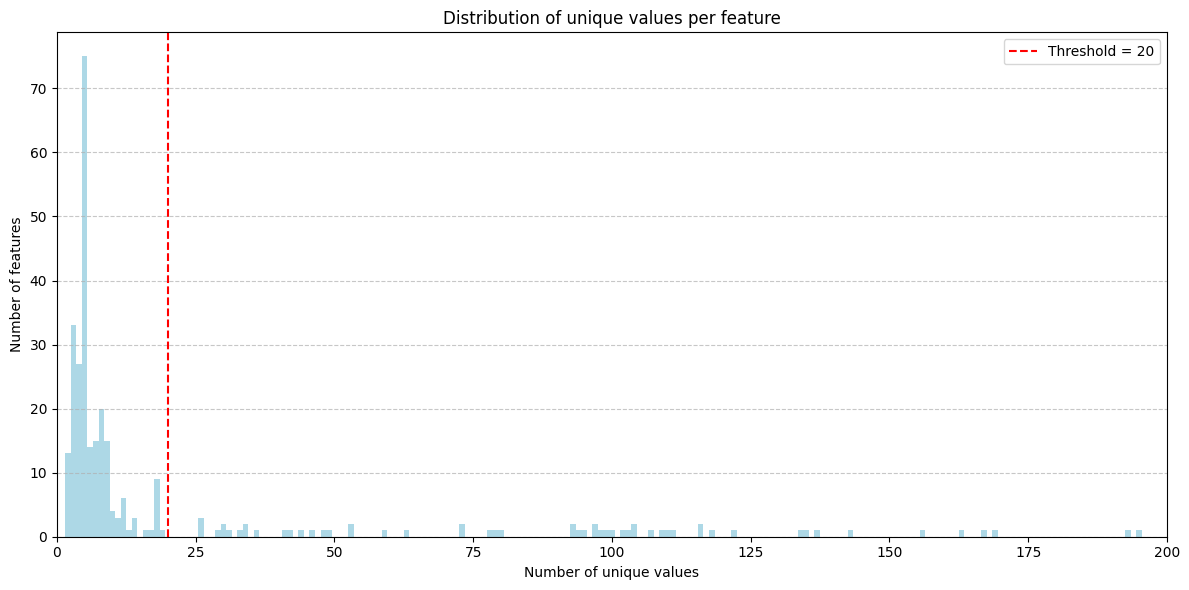

In [12]:
# Fixed threshold
threshold = 20
print(f"Threshold fixed at {threshold} unique values\n")

categorical_idx = []
continuous_idx = []
unique_counts = []

# Compute unique values for every column
for i in range(x_train.shape[1]):
    col = x_train[:, i]
    count = len(np.unique(col))
    unique_counts.append(count)

    if count <= threshold:
        categorical_idx.append(i)
    else:
        continuous_idx.append(i)

# Classifies features as categorical or continuous
print(f"Total categorical features (<= {threshold} unique): {len(categorical_idx)}")
print(f"Total continuous features    (>  {threshold} unique): {len(continuous_idx)}")

# Build histrogram
unique_counts = np.array(unique_counts)
unique_vals, counts = np.unique(unique_counts, return_counts=True)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(unique_vals, counts, color='lightblue', width=1.0)
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Number of unique values')
plt.xlim(right=200)
plt.xlim(left=0)
plt.ylabel('Number of features')
plt.title('Distribution of unique values per feature')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Data cleaning from invalid values and NaN

In [17]:

def remove_outliers_categorical(X,  categorical_idx, threshold=0.99):
    """
    Sostituisce valori anomali o estremi con np.nan.
    threshold = quantile limite (es. 0.99 = sopra il 99° percentile)
    """
    X_clean = X.copy().astype(float)
    for i in range(X.shape[1]):
        if i != categorical_idx: 
             continue

        col = X[:, i]
        col_valid = col[~np.isnan(col)]
        if len(col_valid) == 0:
            continue
        max_val = np.percentile(col_valid, threshold * 100)
        X_clean[col > max_val, i] = np.nan
    return X_clean

x_train_nan = remove_outliers_categorical(x_train,categorical_idx, threshold=0.99 )
x_test_nan = remove_outliers_categorical(x_test,categorical_idx, threshold=0.99 )


In [18]:
nan_ratio = np.mean(np.isnan(x_train), axis=0)
print(f"Number of features with more than 40% of NaN: {np.sum(nan_ratio>0.4)}")

# 1 Drop feature if at least 40% are NaN values
valid_cols = np.where(nan_ratio < 0.4)[0]
x_train_clean = x_train[:, valid_cols]
x_test_clean = x_test[:, valid_cols]
print(f"Shape after dropping cols >40% NaN: {x_train_clean.shape}")

# 2 Identify categorical vs continuous
categorical_idx = []
continuous_idx = []
unique_counts = []
for i in range(x_train_clean.shape[1]):
    count = len(np.unique(x_train_clean[~np.isnan(x_train_clean[:, i]), i]))
    unique_counts.append(count)
    if count <= threshold:
        categorical_idx.append(i)
    else:
        continuous_idx.append(i)

print(f"Categorical features: {len(categorical_idx)}")
print(f"Continuous features: {len(continuous_idx)}")

# 4. Impute NaN differently
# 4a. Continuous → replace NaN with mean
for i in continuous_idx:
    mean_val = np.nanmean(x_train_clean[:, i])
    x_train_clean[np.isnan(x_train_clean[:, i]), i] = mean_val
    x_test_clean[np.isnan(x_test_clean[:, i]), i] = mean_val

# 4b. Categorical → replace NaN with mode
def nanmode(col):
    vals, counts = np.unique(col[~np.isnan(col)], return_counts=True)
    return vals[np.argmax(counts)] if len(vals) > 0 else np.nan

for i in categorical_idx:
    #mode_val = nanmode(x_train_clean[:, i])
    x_train_clean[np.isnan(x_train_clean[:, i]), i] = -1
    x_test_clean[np.isnan(x_test_clean[:, i]), i] = -1

#print("Missing values imputed (mean for continuous, mode for categorical)")
print("Shape x_train_clean:", x_train_clean.shape)

Number of features with more than 40% of NaN: 158
Shape after dropping cols >40% NaN: (328135, 163)
Categorical features: 106
Continuous features: 57
Shape x_train_clean: (328135, 163)


Data cleaning: highly correlated features (multicollinearity, e.g. different scales)

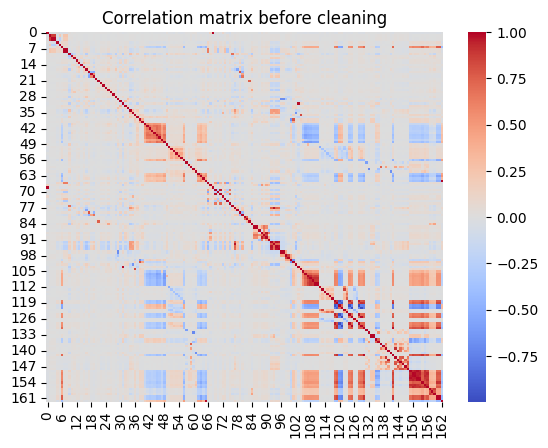

Shape of decorrelated X: (328135, 128)


In [19]:
# Cross-correlation among features
def corrcoef(X):
    n_features = X.shape[1]
    corr = np.empty((n_features, n_features))
    for i in range(n_features):
        for j in range(i, n_features):
            corr_ij = np.corrcoef(X[:, i], X[:, j])[0, 1]       # np.corrcoef returns correlation matrix of two 1D-arrays, corr_ij is in position [0,1]            
            corr[i, j] = corr_ij
            corr[j, i] = corr_ij  
    return corr

corr_matrix = corrcoef(x_train_clean)
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation matrix before cleaning')
plt.show()

# Drop features if correlation > 0.9

non_valid_col = set()  # Use set to avoid duplicates
for i in range(x_train_clean.shape[1]):
    for j in range(i + 1, x_train_clean.shape[1]):
        if abs(corr_matrix[i, j]) > 0.9:
            non_valid_col.add(j)  # Drop j, keep i

x_train_decorr = np.delete(x_train_clean, list(non_valid_col), axis=1)     # Remove column
x_test_decorr = np.delete(x_test_clean, list(non_valid_col), axis=1)
print(f"Shape of decorrelated X: {x_train_decorr.shape}")

Data cleaning: remove low informative features

In [20]:
def drop_low_info_features(X, cont_indices, cat_indices, var_thresh, mode_thresh):
    """
    Removes low-variance features (for continuous variables)
    and high-mode features (for categorical variables),

    """
    
    n_samples = X.shape [0]
    n_features = X.shape [1]
    keep_mask = np.ones(n_features, dtype=bool)
    
    # 1️  continuos feature: variance
    for i in cont_indices:
        var = np.var(X[:, i].astype(float))
        if var < var_thresh:
            keep_mask[i] = False

    # 2️  categorical feature:  mode
    for i in cat_indices:
        col = X[:, i]
        # Find the most frequent value (mode) and its relative frequency, if the latter overcomes a threshold the feaature is dropped since non-informative
        values, counts = np.unique(col, return_counts=True)
        freq_max = counts.max() / n_samples
        if freq_max > mode_thresh:
            keep_mask[i] = False

    # 3️  Filtering valid columns
    X_filtered = X[:, keep_mask]
    
    print(f"Shape after feature removal: {X_filtered.shape}")
    return X_filtered

# Fixed threshold
threshold = 20
categorical_idx = []
continuous_idx = []
unique_counts = []

# Compute unique values for every column
for i in range(x_train_decorr.shape[1]):
    col = x_train_decorr[:, i]
    count = len(np.unique(col))
    unique_counts.append(count)

    if count <= threshold:
        categorical_idx.append(i)
    else:
        continuous_idx.append(i)

x_train_inf= drop_low_info_features(x_train_decorr, cont_indices=continuous_idx, cat_indices=categorical_idx, var_thresh=1e-3, mode_thresh=0.95)
x_test_inf= drop_low_info_features(x_test_decorr, cont_indices=continuous_idx, cat_indices=categorical_idx, var_thresh=1e-3, mode_thresh=0.95)

Shape after feature removal: (328135, 122)
Shape after feature removal: (109379, 122)


Correlation with output

In [21]:
correlations = np.empty(x_train_inf.shape[1])

for i in range(x_train_inf.shape[1]):
    correlations[i] = np.corrcoef(x_train_inf[:, i], y_train)[0, 1]
    
valid_features=np.where(np.abs(correlations)>=0.05)[0]
x_train_denoised=x_train_inf[:,valid_features]
x_test_denoised=x_test_inf[:,valid_features]

print(f"Shape after denoising: {x_train_denoised.shape}")

Shape after denoising: (328135, 39)


Check linearly dependent features

In [22]:
rank = np.linalg.matrix_rank(x_train_denoised)

print(f"Number of features: {x_train_denoised.shape[1]}")
print(f"Rank of the matrix: {rank}")

if rank < x_train_denoised.shape[1]:
    print("Some features are linearly dependent!")


Number of features: 39
Rank of the matrix: 39


In [24]:
def one_hot_encode_columns(X, categorical_cols):
    """
    Applica one-hot encoding solo alle colonne categoriche di X.
    Restituisce il nuovo array e un dizionario con le categorie usate.
    """
    X_encoded = []
    category_map = {}  # per ricordare quali categorie ha ogni colonna

    for i in range(X.shape[1]):
        if i in categorical_cols:
            # valori unici nella colonna
            values = np.unique(X[:, i])
            category_map[i] = values

            # crea una matrice one-hot per ogni valore
            one_hot = np.zeros((X.shape[0], len(values)))
            for j, val in enumerate(values):
                one_hot[:, j] = (X[:, i] == val).astype(float)
            
            X_encoded.append(one_hot)
        else:
            # lascia inalterata la colonna numerica
            X_encoded.append(X[:, i].astype(float).reshape(-1, 1))
    
    # concatenazione finale di tutte le colonne
    X_encoded = np.concatenate(X_encoded, axis=1)
    return X_encoded, category_map

def apply_one_hot_encoding(X, categorical_cols, category_map):
    """
    Applica l'encoding al test set usando le categorie già trovate sul training set.
    Se una categoria non è presente nel training, viene ignorata (colonna tutta 0).
    """
    X_encoded = []

    for i in range(X.shape[1]):
        if i in categorical_cols:
            values = category_map[i]
            one_hot = np.zeros((X.shape[0], len(values)))
            for j, val in enumerate(values):
                one_hot[:, j] = (X[:, i] == val).astype(float)
            X_encoded.append(one_hot)
        else:
            X_encoded.append(X[:, i].astype(float).reshape(-1, 1))

    X_encoded = np.concatenate(X_encoded, axis=1)
    return X_encoded

threshold = 20
print(f"Threshold fixed at {threshold} unique values\n")

categorical_idx = []
continuous_idx = []
unique_counts = []

# Compute unique values for every column
for i in range(x_train_denoised.shape[1]):
    col = x_train_denoised[:, i]
    count = len(np.unique(col))
    unique_counts.append(count)

    if count <= threshold:
        categorical_idx.append(i)
    else:
        continuous_idx.append(i)

X_train_encoded, category_map =  one_hot_encode_columns(x_train_denoised, categorical_idx)
X_test_encoded = apply_one_hot_encoding(x_test_denoised, categorical_idx, category_map)
print(X_train_encoded.shape)

Threshold fixed at 20 unique values

(328135, 183)


Z-score normalization

In [25]:
col_mean_train = np.mean(X_train_encoded[:, continuous_idx], axis=0)
col_std_train = np.std(X_train_encoded[:, continuous_idx], axis=0)

x_train_norm = X_train_encoded.copy()
x_train_norm[:, continuous_idx] = (X_train_encoded[:, continuous_idx] - col_mean_train) / col_std_train

x_test_norm = X_test_encoded.copy()
x_test_norm[:, continuous_idx] = (X_test_encoded[:, continuous_idx] - col_mean_train) / col_std_train

col_mean = np.mean(x_train_norm[:, continuous_idx], axis=0)
col_std = np.std(x_train_norm[:, continuous_idx], axis=0)


print(f"Before normalization, mean: {col_mean_train[0:5]}, std: {col_std_train[0:5]}")
print(f"After normalization, mean: {col_mean[0:5]}, std: {col_std[0:5]}")

Before normalization, mean: [2.01500520e+09 1.73516998e-01 1.21047739e-02 5.78246758e-01
 9.88007985e-03], std: [4.11846911e+03 3.78693609e-01 1.09353776e-01 4.93839493e-01
 9.89063389e-02]
After normalization, mean: [-2.12228109e-11 -5.24892374e-17 -2.07878168e-17 -8.93876122e-17
 -3.60322158e-17], std: [1. 1. 1. 1. 1.]


Classes distribution

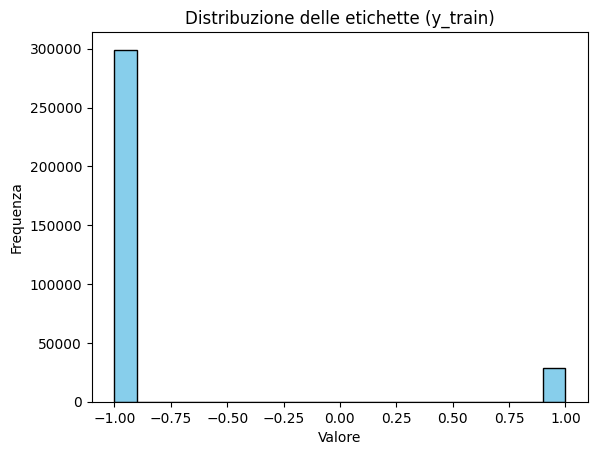

In [26]:
plt.hist(y_train, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribuzione delle etichette (y_train)")
plt.xlabel("Valore")
plt.ylabel("Frequenza")
plt.show()

Save

In [25]:
np.save("processed/x_train.npy", x_train_norm)
np.save("processed/x_test.npy", x_test_norm)
np.save("processed/y_train.npy", y_train)
np.save("processed/train_ids.npy", train_ids)
np.save("processed/test_ids.npy", test_ids)